In [1]:
# Initialize connection to Microwave Office
from matplotlib import pyplot as plt
from numpy import *

import win32com.client
awrde = win32com.client.Dispatch("MWOApp.MWOffice")
print(awrde)

<COMObject MWOApp.MWOffice>


In [4]:
# Locate or create schematic

created = False;
while not awrde.Project.Schematics.Exists('Schema1'):
    
    if created:
        raise SystemExit("Failed to locate schematic.")
    
    print("Schematic not found... ", end="");
    s1 = awrde.Project.Schematics.Add("Schema1");
    print("Creating schematic... ", end="");
    created = True;
print("Schematic found!");

Schematic not found... Creating schematic... Schematic found!


In [6]:
# Create basic circuit if newly created

if created:
    
    p1 = s1.Elements.Add("PORT", 0, 0, 0, False);
    e1_l1 = s1.Elements.Add("IND", 0, 0, 0, False);
    e1_c2 = s1.Elements.Add("CAP", 1e3, 0, -90, False);
    e1_l3 = s1.Elements.Add("IND", 1e3, 0, 0, False);
    p2 = s1.Elements.Add("PORT", 2e3, 0, 180, False);
    e1_gn1 = s1.Elements.Add("GND", 1e3, 1e3, 0, False);
    
    pi = 3.14159;
    f0 = 1e9;
    Z0 = 50;
    L1 = 1.5963 * Z0 * 1/2/pi/f0;
    C2 = 1.0967 / Z0 * 1/2/pi/f0;
    L3 = 1.5963 * Z0 * 1/2/pi/f0;
    
    e1_l1.parameters("L").ValueAsDouble = L1;
    e1_c2.parameters("C").ValueAsDouble = C2;
    e1_l3.parameters("L").ValueAsDouble = L3;
    

In [10]:
# Set circuit frequencies

if created:
    
    vals = linspace(0, 4.09e9, 201, endpoint=True);
    awrde.project.Frequencies.Clear;
    awrde.project.Frequencies.AddMultiple(vals);

In [16]:
# Locate or Create Graph, Set it up

gs = awrde.Project.Graphs

# Locate graph
gcreated = False
while not gs.Exists('Response'):
    
    if gcreated:
        raise SystemExit("Failed to locate graph.")
    
    print("Graph not found... ", end="");
    g1 = gs.Add("Response", 3)
    print("Creating graph... ", end="");
    gcreated = True;
print("Graph found!");

# Set up graph
if gcreated:
    
    meas_S11 = g1.Measurements.Add("Schema1", "DB(|S(1,1)|)")
    meas_S21 = g1.Measurements.Add("Schema1", "DB(|S(2,1)|)")
    meas_S11.SimulateMeasurement()
    
sim = awrde.Project.Simulator.Analyze

g1.Axes.Item(2).Autoscale = False
# g1.Axes.Item(2).Maximumscale = 0
# g1.Axes.Item(2).Minimumscale = -40

Graph not found... Creating graph... Graph found!


In [20]:
# Add markers to graph

g1.Markers.Add("DB(|S(2,1)|)", 1, 1e9)
g1.Markers.Add("DB(|S(2,1)|)", 1, .5e9)

for mk in g1.Markers:
    count = mk.NumDataValueDim
    print(mk.DataValueText)

500 MHz
-0.4994 dB
1000 MHz
-0.5016 dB
500 MHz
-0.4994 dB
1000 MHz
-0.5016 dB
1000 MHz
-0.5016 dB
500 MHz
-0.4994 dB


In [26]:
# Get Trace Data

g2 = gs.Add("Smith", 2)
meas_S11 = g2.Measurements.Add("Schema1", "S(1,1)")
meas_S21 = g2.Measurements.Add("Schema1", "S(2,1)")
meas_S11.SimulateMeasurement()

# Simulate
sim = awrde.Project.Simulator.Analyze

# Get trace data
tv_S11 = array(meas_S11.TraceValues(1))
tv_S21 = array(meas_S21.TraceValues(1))
f_list = tv_S11[:,0]
s11_list = tv_S11[:,1] + 1j*tv_S11[:,2]
s21_list = tv_S21[:,1] + 1j*tv_S21[:,2]

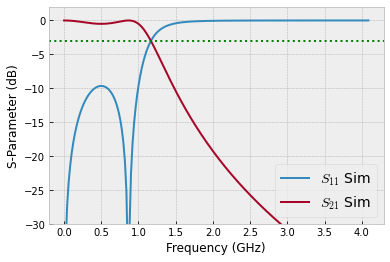

In [29]:
# Plot data

plt.style.use("bmh")
plt.plot(f_list/1e9, 20*log10(abs(s11_list)), label="$S_{11}$ Sim")
plt.plot(f_list/1e9, 20*log10(abs(s21_list)), label="$S_{21}$ Sim")
plt.grid(True)
plt.xlabel("Frequency (GHz)")
plt.ylabel("S-Parameter (dB)");
plt.ylim(-30, 2)
plt.legend(fontsize=14)
plt.axhline(-3, c="g", ls=":")
plt.savefig("lowpassresp.png")
plt.show()